In [ ]:
import random
import warnings
import itertools
import community
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import eigh
from collections import Counter
from itertools import combinations
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import community as com
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, mutual_info_score, adjusted_mutual_info_score

In [ ]:
warnings.filterwarnings("ignore")
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Домашнее задание (24 баллов)

* Для задачи 1 используйте данные:[сеть](https://drive.google.com/file/d/1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5/view?usp=sharing), [метки вершин](https://drive.google.com/file/d/1dC-PWLIE2xGbHZwEgfplICTYZdCvwVxC/view).

* Для задачи 2,3 [данные](https://snap.stanford.edu/data/email-Eu-core.html) (предварительно сделайте сеть ненаправленной).

## 1. Классификация вершин (7 баллов)

Будем решать задачу предсказания влиятельности вершин как задачу бинарной классификации.

1. (1 балла) Разметьте вершины для бинарной классификации: постройте распределение влиятельностей и выберите порог разбиения на два отрезка.  

2. (2 балла) Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

3. (2 балла)  Для каждой метрики центральности постройте AUC-ROC кривую и вычислите соответсвующую площадь. Какая из характеристик лучше классифицирует вершины?

4.  (2 балла) Постройте зависимость площади AUC-ROC от параметра альфа PageRank, определите оптимальное значение параметра.

In [ ]:
spread_data = pd.read_csv("spreading_data_ca-GrQc.csv")
edges_data = np.loadtxt("ca-GrQc.mtx", dtype=int)

In [ ]:
spread_data

,node,spreading ability
0,19,0.000241
1,1,0.000481
2,1751,0.131073
3,2408,0.000241
4,3078,0.001684
...,...,...
4153,3858,0.000241
4154,3859,0.000241
4155,4019,0.000241
4156,4124,0.000241


In [ ]:
G = nx.Graph()
for edge in edges_data:
    G.add_edge(edge[0], edge[1])

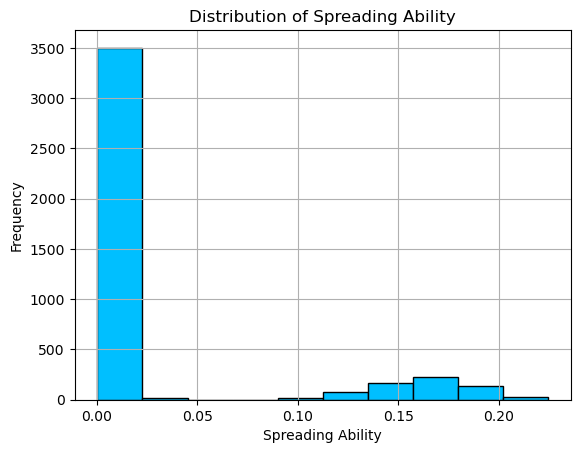

In [ ]:
plt.hist(spread_data["spreading ability"], color="deepskyblue", edgecolor="black")
plt.title("Distribution of Spreading Ability")
plt.xlabel("Spreading Ability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# Choosing threshold for binary classification using threshold factor
threshold_factor = 1.5
threshold = spread_data['spreading ability'].median() * threshold_factor

In [ ]:
threshold

0.0003607503607503

In [ ]:
spread_data["label"] = spread_data["spreading ability"] > threshold

In [ ]:
print(spread_data["label"].value_counts())

label
False    2143
True     2015
Name: count, dtype: int64


In [ ]:
spread_data

,node,spreading ability,label
0,19,0.000241,False
1,1,0.000481,True
2,1751,0.131073,True
3,2408,0.000241,False
4,3078,0.001684,True
...,...,...,...
4153,3858,0.000241,False
4154,3859,0.000241,False
4155,4019,0.000241,False
4156,4124,0.000241,False


In [ ]:
d_centrality = nx.degree_centrality(G)
spread_data["degree centrality"] = [d_centrality[node] for node in G.nodes]

ev_centrality = nx.eigenvector_centrality(G)
spread_data["eigenvector centrality"] = [ev_centrality[node] for node in G.nodes]

cls_centrality = nx.closeness_centrality(G)
spread_data["closeness centrality"] = [cls_centrality[node] for node in G.nodes]

btws_centrality = nx.betweenness_centrality(G)
spread_data["betweenness centrality"] = [btws_centrality[node] for node in G.nodes]

clustering = nx.clustering(G)
spread_data["clustering"] = [clustering[node] for node in G.nodes]

k_core = nx.core_number(G)
spread_data["k_core"] = [k_core[node] for node in G.nodes]

AUC-ROC for degree centrality: 0.7901430842607312
AUC-ROC for eigenvector centrality: 0.6511779158837983
AUC-ROC for closeness centrality: 0.6673738979621333
AUC-ROC for betweenness centrality: 0.6726174302644892
AUC-ROC for clustering: 0.5147275617863853
AUC-ROC for k_core: 0.7650093944211591


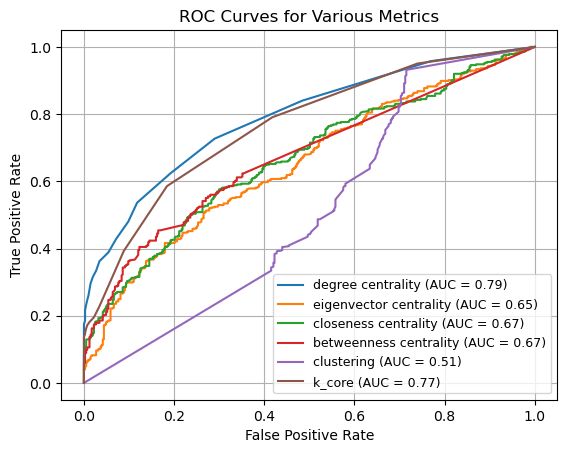

In [ ]:
features = ["degree centrality", "eigenvector centrality",
            "closeness centrality", "betweenness centrality",
            "clustering", "k_core"]
for feature in features:
    X = spread_data[[feature]].values
    y = spread_data["label"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    clf = LogisticRegression()

    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC for {feature}: {auc}")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{feature} (AUC = {auc:.2f})")

plt.title("ROC Curves for Various Metrics")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(prop={"size": 9})
plt.show()

Модель, использующая центральность по степени в качестве признака, дает наилучшую разделяющую способность между положительными и отрицательными классами

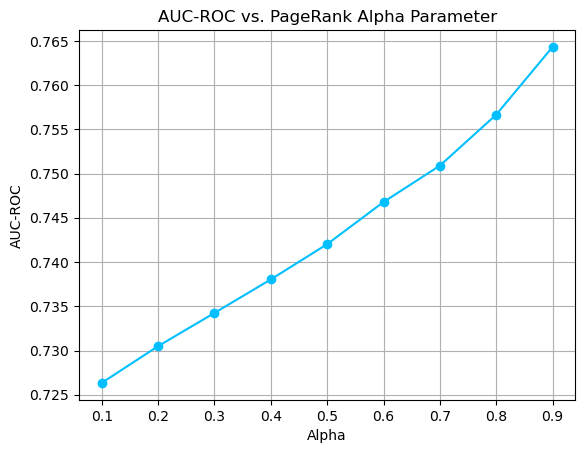

In [ ]:
alphas = np.linspace(0.1, 0.9, 9)
auc_scores = []

for alpha in alphas:
    pagerank = nx.pagerank(G, alpha=alpha)
    spread_data["pagerank"] = [pagerank[node] for node in G.nodes]

    X = spread_data[["pagerank"]].values
    y = spread_data["label"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    clf = LogisticRegression()

    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

plt.plot(alphas, auc_scores, marker="o", color="deepskyblue")
plt.xlabel("Alpha")
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC vs. PageRank Alpha Parameter")
plt.grid(True)
plt.show()

In [ ]:
print("Optimal α:", alphas[np.argmax(auc_scores)])

Optimal α: 0.9


## 2. Предсказание связей (9 баллов)

1. (1 балл) Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована).

2. (2 балла) Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC?

3. (3 балла) Напишите функцию, вычисляющую  Average precision at K (ap@K), определите зависимость ap@K от K для простейших классификаторов, определенных в 2.

4. (3 балла) Постройте модель предсказания на основе вложения (используйте вложение сети с помощью Лапласиана) Сравните качество предсказания с простейшими классификаторами. Здесь можно взять любой бинарный классификатор, который вам нравится и обучить его на спектральных признаках. Исследуйте зависимость от размерности вложения.



In [ ]:
#!wget https://snap.stanford.edu/data/email-Eu-core.txt.gz && gunzip email-Eu-core.txt.gz
#!wget https://snap.stanford.edu/data/email-Eu-core-department-labels.txt.gz && gunzip email-Eu-core-department-labels.txt.gz

In [ ]:
G = nx.read_edgelist("email-Eu-core.txt", nodetype=int)
G_undirected = G.to_undirected()

In [ ]:
all_edges = list(G_undirected.edges())
all_non_edges = list(nx.non_edges(G_undirected))

test_size = min(len(all_edges), len(all_non_edges))

test_edges = random.sample(all_edges, test_size)
test_non_edges = random.sample(all_non_edges, test_size)

test_set = [(u, v, 1) for u, v in test_edges] + [(u, v, 0) for u, v in test_non_edges]

In [ ]:
len(test_set)

33412

AUC-ROC для degree centrality: 0.7506610532767276
AUC-ROC для clustering: 0.6404891659841832
AUC-ROC для k_core: 0.7315990186573382


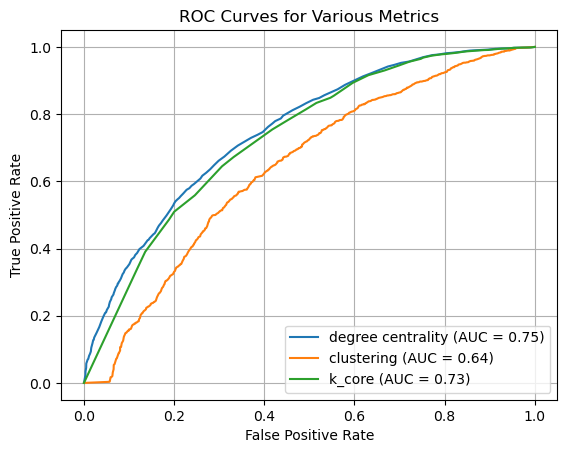

In [ ]:
G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))

features = ["degree centrality", "clustering", "k_core"]
y_true_all = []
y_pred_proba_all = []

for feature in features:
    if feature == "degree centrality":
        feature_values = nx.degree_centrality(G_undirected)
    elif feature == "clustering":
        feature_values = nx.clustering(G_undirected)
    elif feature == "k_core":
        feature_values = nx.core_number(G_undirected)

    X = np.array([feature_values[u] for u, _, _ in test_set])
    y = np.array([label for _, _, label in test_set])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    clf = LogisticRegression()

    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(X_train.reshape(-1, 1), y_train)
    y_pred_proba = pipeline.predict_proba(X_test.reshape(-1, 1))[:, 1]

    y_true_all.append(y_test)
    y_pred_proba_all.append(y_pred_proba)

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC для {feature}: {auc}")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{feature} (AUC = {auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Various Metrics")
plt.grid(True)
plt.legend()
plt.show()

Лучше всего с задаче предсказания связей справляется характеристика центральность по степени

Average Precision at K for feature 1:
  AP@1: 0.0
  AP@10: 0.00207058030630505
  AP@100: 0.02228945705447626
  AP@500: 0.11169046570519967
  AP@1000: 0.2040951341577418
  AP@2000: 0.36347128840131515
  AP@5000: 0.6788244880020018
  AP@10000: 0.7391584254131597
Average Precision at K for feature 2:
  AP@1: 0.0
  AP@10: 0.0
  AP@100: 5.6192076274904646e-05
  AP@500: 0.026171424547922897
  AP@1000: 0.0884521251385515
  AP@2000: 0.20931065307146232
  AP@5000: 0.5013513541006658
  AP@10000: 0.5865634577963303
Average Precision at K for feature 3:
  AP@1: 0.00029282576866764275
  AP@10: 0.0026061493411420208
  AP@100: 0.018514779296427437
  AP@500: 0.08329749367137584
  AP@1000: 0.1671759579769916
  AP@2000: 0.32710837295079
  AP@5000: 0.6378431226607751
  AP@10000: 0.6998182979716745


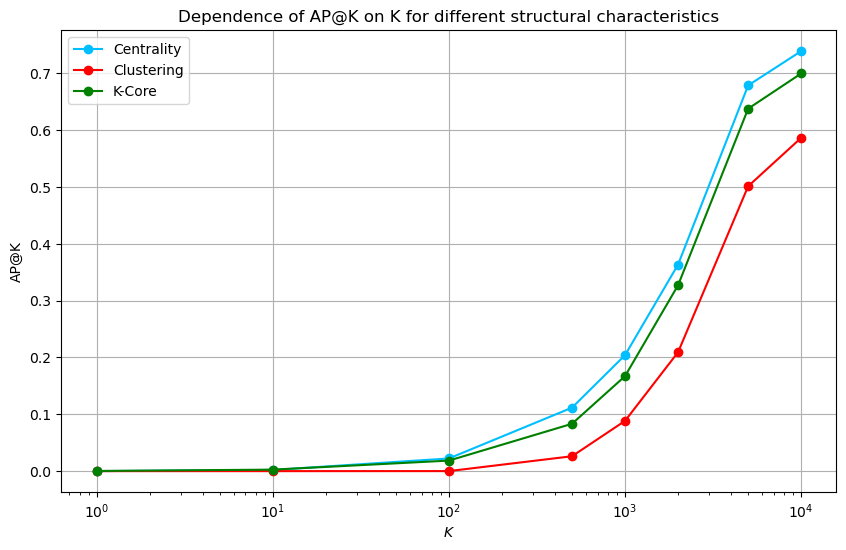

In [ ]:
def average_precision_at_k(y_true, y_pred_proba, k):
    # Sorting predicted probabilities and their true labels
    y_true_sorted, y_pred_proba_sorted = zip(*sorted(zip(y_true, y_pred_proba), key=lambda x: x[1], reverse=True))

    # Calculating precision@k и recall@k
    num_positive = sum(y_true)
    num_relevant_at_k = sum(y_true_sorted[:k])

    precision_at_k = num_relevant_at_k / k if k > 0 else 0

    # Calculating AP@K
    ap_at_k = 0
    num_relevant = 0
    for i in range(min(len(y_true), k)):
        if y_true_sorted[i] == 1:
            num_relevant += 1
            ap_at_k += num_relevant / (i + 1)

    if num_positive == 0:
        return 0

    ap_at_k /= num_positive

    return ap_at_k


K_values = [1, 10, 100, 500, 1000, 2000, 5000, 10000]

ap_centrality = []
ap_clustering = []
ap_k_core = []

for feature_idx in range(len(y_true_all)):
    y_true = y_true_all[feature_idx]
    y_pred_proba = y_pred_proba_all[feature_idx]
    ap_values = []
    for k in K_values:
        ap_at_k = average_precision_at_k(y_true, y_pred_proba, k)
        ap_values.append(ap_at_k)
    if feature_idx == 0:
        ap_centrality = ap_values
    elif feature_idx == 1:
        ap_clustering = ap_values
    elif feature_idx == 2:
        ap_k_core = ap_values

for i, ap_values in enumerate([ap_centrality, ap_clustering, ap_k_core]):
    print(f"Average Precision at K for feature {i + 1}:")
    for j, k in enumerate(K_values):
        print(f"  AP@{k}: {ap_values[j]}")

plt.figure(figsize=(10, 6))
plt.plot(K_values, ap_centrality, marker="o", label="Centrality", color="deepskyblue")
plt.plot(K_values, ap_clustering, marker="o", label="Clustering", color="red")
plt.plot(K_values, ap_k_core, marker="o", label="K-Core", color="green")
plt.xscale("log")
plt.xlabel("$K$")
plt.ylabel("AP@K")
plt.title("Dependence of AP@K on K for different structural characteristics")
plt.legend()
plt.grid(True)
plt.show()

С увеличением параметра K растёт показатель AP@K для выбранных характеристик

In [ ]:
def spectral_embedding_classification(G, test_size, label, embedding_dim):
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    embedding_dim = min(embedding_dim, len(eigenvalues) - 2)

    # Extraction of the first "embedding_dim" eigenvectors
    X = eigenvectors[:, 1:embedding_dim+1]

    # Test set
    all_edges = list(G.edges())
    all_non_edges = list(nx.non_edges(G))
    test_edges = random.sample(all_edges, int(test_size * len(all_edges)))
    test_non_edges = random.sample(all_non_edges, int(test_size * len(all_edges)))
    test_data = [(u, v, label) for u, v in test_edges] + [(u, v, 0) for u, v in test_non_edges]
    X_test = np.array([X[u] - X[v] for u, v, _ in test_data])
    y_test = np.array([label for _, _, label in test_data])

    # Training set
    train_edges = [edge for edge in all_edges if edge not in test_edges]
    train_non_edges = [non_edge for non_edge in all_non_edges if non_edge not in test_non_edges]
    train_data = [(u, v, label) for u, v in train_edges] + [(u, v, 0) for u, v in train_non_edges]
    X_train = np.array([X[u] - X[v] for u, v, _ in train_data])
    y_train = np.array([label for _, _, label in train_data])

    # Training on spectral features
    scaler = StandardScaler()
    clf = LogisticRegression()
    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    return y_pred_proba, y_test, X_train, y_train


y_pred_proba, y_test, X_train, y_train = spectral_embedding_classification(G_undirected, test_size=TEST_SIZE, label=1, embedding_dim=2)

In [ ]:
roc_auc_embedding = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC for the embedding-based classifier:", roc_auc_embedding)

ROC AUC for the embedding-based classifier: 0.4775955941992125


Модель предсказания на основе вложения показала производительность хуже чем все простейшие классификаторы

## 3. Задача кластеризации (8 баллов)

 Каждый сотрудник относится к одному из департаментов, которые и являются истинными сообществами в сети.

1.  ( 2 балла) Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем?

2. ( 2 балла) напишите функцию, вычисляющую [Rand индекс](https://en.wikipedia.org/wiki/Rand_index).

3. (2 балла) Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества (Rand индекс, взаимная информация, модулярность)  от числа задаваемых сообществ.
Какое разбиение оказывается более близким к истинному?

3. (2 балла) Определите сообщества любым другим методом (из семинара 9). Сколько сообществ вы получили? Сравните метрики качества.


In [ ]:
df = pd.read_csv("email-Eu-core-department-labels.txt", sep=" ", header=None, names=["node", "department"])

In [ ]:
department_labels = dict(zip(df["node"], df["department"]))
nx.set_node_attributes(G, department_labels, "department")
departments = nx.get_node_attributes(G, "department")
size_departments = Counter(departments.values())

In [ ]:
df

,node,department
0,0,1
1,1,1
2,2,21
3,3,21
4,4,21
...,...,...
1000,1000,4
1001,1001,21
1002,1002,1
1003,1003,6


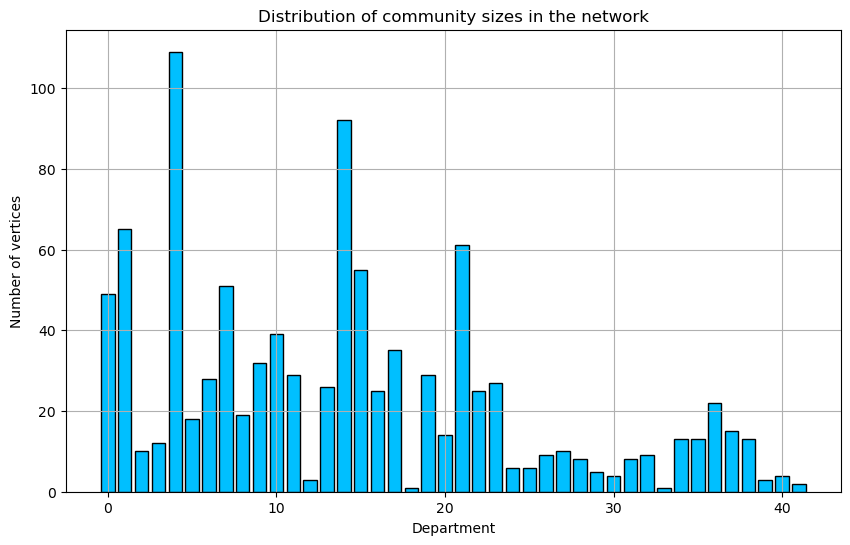

In [ ]:
community_sizes = df["department"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(community_sizes.index, community_sizes.values, color="deepskyblue", edgecolor="black")
plt.title("Distribution of community sizes in the network")
plt.xlabel("Department")
plt.ylabel("Number of vertices")
plt.grid(True)
plt.show()

In [ ]:
largest_community_ratio = community_sizes.max() / df.shape[0]
smallest_community_ratio = community_sizes.min() / df.shape[0]

print(f"Ratio of vertices in the largest community: {largest_community_ratio}")
print(f"Ratio of vertices in the smallest community: {smallest_community_ratio}")

Ratio of vertices in the largest community: 0.10845771144278607
Ratio of vertices in the smallest community: 0.0009950248756218905


In [ ]:
def rand_index(labels_true, labels_pred):
    if len(labels_true) != len(labels_pred):
        raise ValueError()

    a, b = 0, 0
    for (i, j) in combinations(range(len(labels_true)), 2):
        same_true = labels_true[i] == labels_true[j]
        same_pred = labels_pred[i] == labels_pred[j]

        if same_true and same_pred:
            a += 1
        elif not same_true and not same_pred:
            b += 1

    total_pairs = len(labels_true) * (len(labels_true) - 1) / 2
    rand_index_value = (a + b) / total_pairs

    return rand_index_value

true_labels = df["department"].values
predicted_labels = df["node"].values
rand_index_value = rand_index(true_labels, predicted_labels)
print(f"Rand index: {rand_index_value}")

Rand index: 0.95333293690908


In [ ]:
def similarity_matrix(G, nodelist=None):
    # If nodelist is not provided, use the default node order
    if nodelist is None:
        nodelist = list(G.nodes)

    Smatrix = np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i + 1:], start=i + 1):
            # Calculate the similarity score
            common_neighbors = set(G[node1]) & set(G[node2])
            edge_exists = int(G.has_edge(node1, node2))
            denominator = np.min([len(G[node1]), len(G[node2])]) + 1 - edge_exists
            similarity_score = (len(common_neighbors) + edge_exists) / denominator

            # Assign the similarity score to both positions in the matrix
            Smatrix[i, j] = similarity_score
            Smatrix[j, i] = similarity_score

    return Smatrix

In [ ]:
rand_indexes = []
mutual_infos = []
modularities = []

N_CLUSTERING = np.arange(2, 60, 5)

X = similarity_matrix(G, nodelist=None)

groups = set(departments.values())
mapping = dict(zip(sorted(groups), itertools.count()))
nodes = G.nodes()
y_true = [mapping[G.nodes[n]['department']] for n in nodes]
y_true = np.array(y_true)

for n_clusters in N_CLUSTERING:

    communities = AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
    communities.fit(X)

    y_pred = communities.labels_

    rand_index_value = rand_index(y_true, y_pred)
    mutual_info = adjusted_mutual_info_score(y_true, y_pred)

    coms = {i: [] for i in range(n_clusters)}
    for i, label in enumerate(y_pred):
        coms[label].append(i)

    coms = list(coms.values())

    modularity_score = com.modularity(G, coms)

    rand_indexes.append(rand_index_value)
    mutual_infos.append(mutual_info)
    modularities.append(modularity_score)


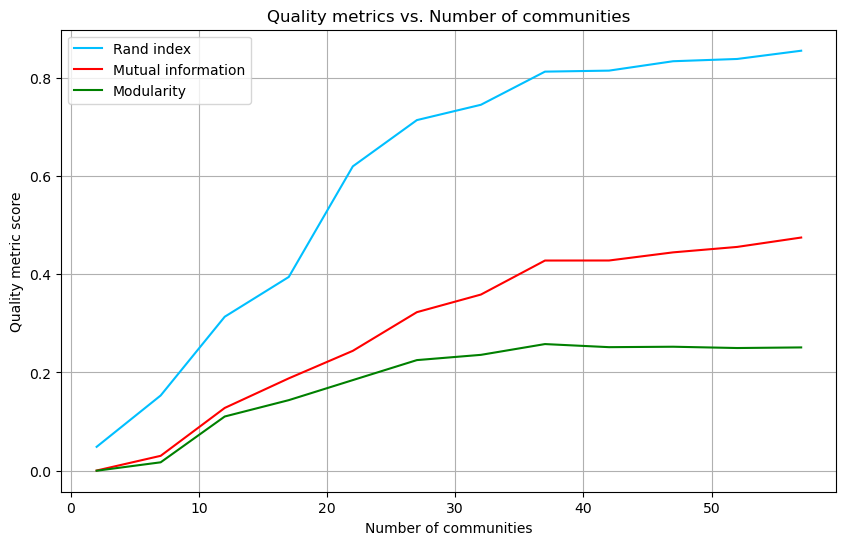

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(N_CLUSTERING, rand_indexes, label="Rand index", color="deepskyblue")
plt.plot(N_CLUSTERING, mutual_infos, label="Mutual information", color="red")
plt.plot(N_CLUSTERING, modularities, label="Modularity", color="green")

plt.title("Quality metrics vs. Number of communities")
plt.xlabel("Number of communities")
plt.ylabel("Quality metric score")
plt.legend()
plt.grid(True)
plt.show()


Наиболее близким к истиному оказыватеся разбиение на 38 сообществ

In [ ]:
# Clauset-Newman-Moore method
cnm = nx.community.greedy_modularity_communities(G)

In [ ]:
print(cnm)

[frozenset({2, 3, 4, 10, 16, 20, 21, 22, 28, 31, 42, 45, 46, 49, 50, 54, 55, 56, 57, 58, 59, 62, 63, 66, 67, 68, 69, 70, 71, 72, 77, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 96, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 117, 118, 121, 126, 131, 132, 137, 138, 142, 144, 145, 147, 152, 153, 154, 155, 158, 159, 162, 163, 169, 170, 173, 174, 175, 184, 186, 187, 188, 189, 190, 192, 193, 194, 195, 208, 209, 210, 211, 212, 217, 230, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 249, 252, 253, 254, 255, 256, 258, 259, 260, 269, 271, 279, 281, 282, 285, 286, 287, 288, 298, 299, 300, 302, 303, 304, 305, 306, 319, 325, 326, 327, 328, 329, 333, 355, 356, 357, 363, 364, 365, 366, 367, 369, 371, 372, 373, 375, 400, 404, 405, 408, 410, 411, 412, 416, 418, 420, 422, 424, 427, 431, 432, 433, 434, 453, 454, 460, 462, 465, 467, 469, 471, 472, 473, 474, 475, 476, 477, 478, 480, 481, 489, 490, 492, 508, 509, 512, 513, 514, 518, 520, 524, 531, 532, 533, 536, 538, 540, 546, 549, 550,

In [ ]:
partition = list(cnm)

labels_true = []
for i, nodes in enumerate(partition):
    for node in nodes:
        labels_true.append(i)

ami_score = adjusted_mutual_info_score(labels_true,y_pred)
num_communities = len(set(cnm))
modularity= com.modularity(G, cnm)
print(f"Number of communities: {num_communities}")
print(f"Modularity: {modularity}")
print(f"Adjusted Mutual Info Score: {ami_score}")

Number of communities: 44
Modularity: 0.3665850161916692
Adjusted Mutual Info Score: 0.044803605952997684


Обнаружено 44 сообщества